# Analysis of heterophonic pitch synchrony in jingju music

This notebook performs statistical analyses to extract insights about level of heterophonic pitch synchrony between the vocal melody and the instrumental accompaniment in jingju music. 

Jingju singing is accompanied by an instrumental ensemble in heterophony. Here, the level of heterophonic pitch synchrony is revealed by the distribution of the musical intervals formed between the vocal melody and the lead instrument in the ensemble (jinghu).

These analyses are significantly inspired and use the <a href = "https://compmusic.upf.edu/node/348">Jingju Music Scores Collection</a> from: Repetto, R. C., & Serra, X. (2017). <a href = "https://repositori.upf.edu/handle/10230/32603">A collection of music scores for corpus based jingju singing research</a>. This collection is part of the corpus gathered in the <a href = "https://compmusic.upf.edu/">CompMusic</a> project for jingju music research and offers a comprehensive and complete resource for the study of jingju singing in terms of its musical system.

Note: Each cell begins with a comment that explains what is done in that cell.

In [1]:
# imports 
import csv
import matplotlib.pyplot as plt
from music21 import *
import pandas as pd
pd.set_option('display.max_columns', 500)
from IPython.display import display

The next cell defines three different classes that are used to parse the csv files that come with the score collection and to store the intervals provided by the analyses.

The `Score` class has 7 attributes:   
- `title` (in Chinese)
- `couplets`: dictionary with line types as keys and instantiations of the line class as values. 
- `voiceStaves`: staves with lyrics in the collection
- `instrumentalStaves`: staves without lyrics in the collection
- `separatedAccompaniment`: 'yes' or 'no' the original score contained a separated line for the accompaniment.
- `intervalsSS`: intervals that sound simultaneously (instance of the interval class)
- `intervalsPS`: intervals that are played simultaneously (instance of the interval class)


The `Line` class has 6 attributes:
- `shengqiang`
- `banshi`
- `role type`
- `lyrics`
- `startOffset`
- `endOffset`

The `Interval` class is designed to store intervals according to three categories (` shengqiang`, `banshi` and` role type`) which in turn are its attributes.

In [2]:
# class definitions
class Score:        
    def __init__(self, title):
        self.title = title
        self.couplets = []
        self.voiceStaves = []
        self.instrumentalStaves = []
        self.separatedAccompaniment = ''
        self.intervalsSS = Intervals()
        self.intervalsPS = Intervals()
    
    def __str__(self):
        return self.title

class Line:
    def __init__(self, shengqiang = '', banshi = '', roleType = '', lyrics = '', startOffset = '', endOffset = ''):
        self.shengqiang = shengqiang
        self.banshi = banshi
        self.roleType = roleType
        self.lyrics  = lyrics
        self.startOffset = startOffset
        self.endOffset = endOffset
        
    def __str__(self):
        return self.lyrics

    
class Intervals:
    def __init__(self):
        self.shengqiang = {}
        self.banshi = {}
        self.roleType = {}

    def __str__(self):
        return 'shengqiang:' + str(self.shengqiang) + ', banshi' + str(self.banshi) + ', roleType' + str(self.roleType)

In [3]:
# This cell instantiates 92 Score objects when parsing the csv files that come with the score collection
path_folder = './JingjuMusicScoresCollection/MusicXML/'

lines_data_path = path_folder + 'lines_data.csv'
scoreList = [] # Score objects created when parsing the csv file
Couplet = {'openingLine': '', 'kLine': '', 'closingLine': ''}
row_count = 0

with open(lines_data_path, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        # Store the previous score if a new one is found
        if row[0] != '': # Start of a new score
            if row_count != 0: # Skip the first score
                score.couplets = score_couplets
                scoreList.append(score)
            
            # Updating the score object with a new one
            title = row[0]
            score = Score(title)
            score_couplets = [] # Init the couplet array of the score
        
        if row[1] != '': # important for scores with multiple voice staves
            if Couplet['closingLine'] != '':
                Couplet = {'openingLine': '', 'kLine': '', 'closingLine': ''}

            # Create a new Line object
            line = Line()
            line.roleType = row[1]
            line.shengqiang = row[2]            
            line.banshi = row[3]
            lineType = row[4]
            line.lyrics = row[5]
            line.startOffset = row[6]
            line.endOffset = row[7]

            if lineType.startswith('s'):
                Couplet['openingLine'] = line
            else:
                if lineType.startswith('k'):
                    Couplet['kLine'] = line
                else:
                    Couplet['closingLine'] = line

            # Append the couplet if the current line is a closing line 
            if Couplet['closingLine'] != '':
                score_couplets.append(Couplet)
            
            # Increment the row count
            row_count += 1
    
    # Store the last score
    score.couplets = score_couplets
    scoreList.append(score)
    
print('{} Scores parsed'.format(len(scoreList)))

92 Scores parsed


The scores in the collection have two or three parts. There is no agreement between the original sources about which parts correspond to the voice staves and which parts correspond to the lead instrument. The following cell automatically classifies and keeps track of the vocal parts as those that have lyrics, and the instrumental parts as those that don't.

In [4]:
# classifying and keeping track of parts
for score in scoreList:
    s = converter.parse(path_folder + score.title)

    vocalParts = []
    instrumentalPart = []
    for staff, p in enumerate(s.parts):
        nn = p.flat.notes.stream() # only notes are needed when looking for lyrics
        i = 0
        if len(nn) != 0: # for a special case: lsxp-YiZhuangZhuang-QunYingHui
            n = nn[i]
            while n.quarterLength == 0: # lyrics are only attached to main notes
                i += 1
                n = nn[i]
            if n.lyric != None:
                vocalParts.append(staff)
            else:
                instrumentalPart.append(staff)
        else:
            instrumentalPart.append(staff)
            
    score.voiceStaves = vocalParts
    score.instrumentalStaves = instrumentalPart

# Special cases
# lsxp-YiZhuangZhuang-QunYingHui - the instrumental staff is all silence
# sdxp-DangNianHan-SanJiZhang - there is no have instrumental staff

The score collection transnotations almost always (except for the `sdxp-DangNianHan-SanJiZhang` score) present each voice line and the jinghu line in independent staves. For these analyses, only those scores whose vocal part does not have exactly the same melody as the instrumental part (when there is voice melody) are useful, and in the collection are those whose original scores contain a separate line for the accompaniment.

In the following cell, first the `separatedAccompaniment` attribute of the `Score` objects is set with the appropriate annotation from the `scores_data.csv` file of the collection, and then the `ScoreList` is filtered to consider only these scores.

Of the 92 scores, 53 (57.61 %) of them contain a separate line for the accompaniment.

In [5]:
# filtering scores with separatedAccompaniment

# setting separatedAccompaniment attribute
path_folder = './JingjuMusicScoresCollection/MusicXML/'
lines_data_path = path_folder + 'scores_data.csv'

with open(lines_data_path, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        score = list(filter(lambda x : x.title == row[0]+'.xml', scoreList))[0]
        score.separatedAccompaniment = row[5]
        
filteredScoreList = list(filter(lambda x : x.separatedAccompaniment == 'yes', scoreList))

print('{} filtered scores'.format(len(filteredScoreList)))

53 filtered scores


The following two cells define the functions that compute the number of intervals per type and per category (` shengqiang`, `banshi` and` role type`) in each score. These intervals are store in the `intervalsSS` and `intervalsPS` attributes of the `Score` objects.

The `compIntervalsSS` function deals with the intervals between notes that sound simultaneously, that is to say, intervals formed between each note in the accompaniment and the corresponding sounding note in the singing melody.

The `compIntervalsPS` function deals with the intervals between notes that are played simultaneously, that is to say, intervals formed between the singing and accompaniment notes that are played at the same time.

In [6]:
# computing the number of intervals per type and per category between notes that sound simultaneously
def compIntervalsSS(score):
    path_folder = './JingjuMusicScoresCollection/MusicXML/'
    
    s = converter.parse(path_folder + score.title)

    pi = s.parts[score.instrumentalStaves[0]] # Instrumental part
    ni = pi.flat.notes.stream() # All notes from the instrumental part
        
    for vS in score.voiceStaves:
        pv = s.parts[vS] # Vocal part
        nv = pv.flat.notes.stream() # All notes for the vocal part

        for n1 in ni:
            if n1.quarterLength > 0: # Skip grace notes
                o = n1.offset
                
                flag_found = 0
                for lines in score.couplets:
                    for line in lines.values():
                        if line != '': # skip kLine when it does not exist
                            if o >= float(line.startOffset) and o <= float(eval(line.endOffset)):
                                shengqiang = line.shengqiang
                                banshi = line.banshi
                                roleType = line.roleType
                                flag_found = 1
                                break
                    if flag_found:
                        break
                
                # Retrieve the notes in the vocal part that occur at the instrumental note's offset.
                # The mustBeginInSpan=False parameter allows retrieving notes that started before that
                # offset and are still sounding at that position.
                # The result is a stream, which might contain more than one note in case there are
                # grace notes, which share the offset with the main note.
                nStr = nv.getElementsByOffset(o, mustBeginInSpan=False).stream()
                for n2 in nStr:
                    if n2.quarterLength > 0: # Skip grace notes
                        itv = interval.Interval(n1, n2)

                        iSSShengqiang = score.intervalsSS.shengqiang # simplified notation with a reference
                        if iSSShengqiang.get(shengqiang) == None: # create if not exist
                            iSSShengqiang[shengqiang] = {} 
                        iSSShengqiang[shengqiang][itv.name] = iSSShengqiang[shengqiang].get(itv.name, 0) + 1

                        iSSBanshi = score.intervalsSS.banshi # simplified notation with a reference
                        if iSSBanshi.get(banshi) == None: # create if not exist
                            iSSBanshi[banshi] = {} 
                        iSSBanshi[banshi][itv.name] = iSSBanshi[banshi].get(itv.name, 0) + 1

                        iSSRoleType = score.intervalsSS.roleType # simplified notation with a reference
                        if iSSRoleType.get(roleType) == None: # create if not exist
                            iSSRoleType[roleType] = {} 
                        iSSRoleType[roleType][itv.name] = iSSRoleType[roleType].get(itv.name, 0) + 1

In [7]:
# computing the number of intervals per type and per category between notes that are played simultaneously
def compIntervalsPS(score):
    path_folder = './JingjuMusicScoresCollection/MusicXML/'
    
    s = converter.parse(path_folder + score.title)

    pi = s.parts[score.instrumentalStaves[0]] # Instrumental part
    ni = pi.flat.notes.stream() # All notes from the instrumental part
        
    for vS in score.voiceStaves:
        pv = s.parts[vS] # Vocal part
        nv = pv.flat.notes.stream() # All notes for the vocal part

        for n1 in ni:
            if n1.quarterLength > 0: # Skip grace notes
                o = n1.offset
                
                flag_found = 0
                for lines in score.couplets:
                    for line in lines.values():
                        if line != '': # skip kLine when it does not exist
                            if o >= float(line.startOffset) and o <= float(eval(line.endOffset)):
                                shengqiang = line.shengqiang
                                banshi = line.banshi
                                roleType = line.roleType
                                flag_found = 1
                                break
                    if flag_found:
                        break
                
                nStr = nv.getElementsByOffset(o).stream()
                for n2 in nStr:
                    if n2.quarterLength > 0: # Skip grace notes
                        itv = interval.Interval(n1, n2)

                        iPSShengqiang = score.intervalsPS.shengqiang # simplified notation with a reference
                        if iPSShengqiang.get(shengqiang) == None: # create if not exist
                            iPSShengqiang[shengqiang] = {} 
                        iPSShengqiang[shengqiang][itv.name] = iPSShengqiang[shengqiang].get(itv.name, 0) + 1

                        iPSBanshi = score.intervalsPS.banshi # simplified notation with a reference
                        if iPSBanshi.get(banshi) == None: # create if not exist
                            iPSBanshi[banshi] = {} 
                        iPSBanshi[banshi][itv.name] = iPSBanshi[banshi].get(itv.name, 0) + 1

                        iPSRoleType = score.intervalsPS.roleType # simplified notation with a reference
                        if iPSRoleType.get(roleType) == None: # create if not exist
                            iPSRoleType[roleType] = {} 
                        iPSRoleType[roleType][itv.name] = iPSRoleType[roleType].get(itv.name, 0) + 1

In [8]:
# applying compIntervals functions to the filteredScoreList
for score in filteredScoreList:
    compIntervalsSS(score)
    compIntervalsPS(score)

In [9]:
# printing the score list
def print_score_list(scoreList):
    print('{} Scores'.format(len(scoreList)))
    for s in scoreList:
        print('Score {} containing {} couplets'.format(s.title, len(s.couplets)))
        print('Voice staves: {}'.format(s.voiceStaves))
        print('Instrumental staves: {}'.format(s.instrumentalStaves))
        print('Separated accompaniment: {}'.format(s.separatedAccompaniment))
        print('IntervalsSS: {}'.format(s.intervalsSS))
        print('IntervalsPS: {}'.format(s.intervalsPS))
        count = 1
        for l in s.couplets:
            print('\tCouplet {}'.format(count))
            print('\tOpening line: {}'.format(l['openingLine']))
            if l['kLine'] != '':
                print('\tK line: {}'.format(l['kLine']))
            print('\tClosing line: {}'.format(l['closingLine']))
            print('\n')
            count += 1

print_score_list(filteredScoreList)

53 Scores
Score daeh-CanQiQi-WuLongZuo.xml containing 2 couplets
Voice staves: [1]
Instrumental staves: [0]
Separated accompaniment: yes
IntervalsSS: shengqiang:{'erhuang': {'P8': 342, 'm7': 39, 'm6': 7, 'P4': 7, 'P1': 35, 'P5': 6, 'M9': 17, 'm3': 6, 'm10': 6, 'M6': 4, 'M2': 3, 'M7': 1, 'P12': 2, 'P11': 2, 'm2': 1, 'M10': 1}}, banshi{'manban': {'P8': 342, 'm7': 39, 'm6': 7, 'P4': 7, 'P1': 35, 'P5': 6, 'M9': 17, 'm3': 6, 'm10': 6, 'M6': 4, 'M2': 3, 'M7': 1, 'P12': 2, 'P11': 2, 'm2': 1, 'M10': 1}}, roleType{'dan': {'P8': 342, 'm7': 39, 'm6': 7, 'P4': 7, 'P1': 35, 'P5': 6, 'M9': 17, 'm3': 6, 'm10': 6, 'M6': 4, 'M2': 3, 'M7': 1, 'P12': 2, 'P11': 2, 'm2': 1, 'M10': 1}}
IntervalsPS: shengqiang:{'erhuang': {'P8': 239, 'P1': 30, 'P5': 2, 'M7': 1, 'm10': 3, 'P11': 1, 'm2': 1, 'M6': 2, 'M10': 1, 'm7': 2, 'M9': 1, 'm3': 1}}, banshi{'manban': {'P8': 239, 'P1': 30, 'P5': 2, 'M7': 1, 'm10': 3, 'P11': 1, 'm2': 1, 'M6': 2, 'M10': 1, 'm7': 2, 'M9': 1, 'm3': 1}}, roleType{'dan': {'P8': 239, 'P1': 30, 'P

	Couplet 2
	Opening line: 杨廷辉有一日愁眉得展，
	Closing line: 誓不忘贤公主恩重如山。


	Couplet 3
	Opening line: 非是我这几日愁眉不展，
	Closing line: 有一桩心腹事不敢明言。


	Couplet 4
	Opening line: 萧天佐摆天门两国交战，
	Closing line: 我的娘押粮草来到北番。


	Couplet 5
	Opening line: 我有心回宋营见母一面，
	Closing line: 怎奈我身在番难以过关。


	Couplet 6
	Opening line: 公主虽然不阻拦，
	Closing line: 无有令箭怎过关。


	Couplet 7
	Opening line: 公主赠我的金鈚箭，
	Closing line: 见母一面即刻还。


	Couplet 8
	Opening line: 宋营（哪）虽然路途远，
	Closing line: 快马加鞭我一夜还。


	Couplet 9
	Opening line: 公主叫我盟誓愿，
	Closing line: 将身跪在地平川。


	Couplet 10
	Opening line: 我若探母不回转，
	Closing line: 黄沙盖脸尸骨不全。


	Couplet 11
	Opening line: 讲什么夫妻情恩德不浅，
	Closing line: 咱与你隔南北千里姻缘。


	Couplet 12
	Opening line: 因何故终日里愁眉不展，
	Closing line: 有什么心腹事你只管明言。


	Couplet 13
	Opening line: 你那里休得要巧言舌辨，
	Closing line: 你要见高堂母我不阻拦。


	Couplet 14
	Opening line: 有心赠你金鈚箭，
	Closing line: 怕你一去就不回还。


	Couplet 15
	Opening line: 宋营离此路途远，
	Closing line: 一夜之间你怎能回还。


	Couplet 16
	Opening line: 适才叫咱盟誓愿，
	Closing line: 你也对苍天就表一番。




The following cell defines a function that adds the intervals in a score list inputed in the first argument. The type of intervals to be summarized in the score list can be set in the `intervalType` argument.

Since the number of `banshi` in the collection is relatively high (`12`), here the `bashi` are grouped according to their tempo ranges, like this:
- `yuanban`: `yuanban` and `erliu` - 2/4 metre and medium tempo ranges.
- `manban`: `manban`, `sanyan`, `zhongsanyan`, `kuaisanyan` - 4/4 metre and slow tempo.
- `kuaiban`: `kuaiban` and `liushui` - 1/4 metre and fast tempo.

In [10]:
# summarizing the intervals in a score list
def summarizeIntervals(scoreList, intervalType = 'SS'):
    I = Intervals() # object to store summarized intervals
    
    # banshi groups
    BGs ={'yuanban':'yuanban', 'erliu':'yuanban',
          'manban': 'manban', 'sanyan': 'manban', 'zhongsanyan': 'manban', 'kuaisanyan': 'manban', 
          'kuaiban': 'kuaiban', 'liushui': 'kuaiban',
          'daoban': '', 'sanban': '', 'yaoban':''} 
    
    for score in scoreList:
        if intervalType == 'SS':
            scoreIntervals = score.intervalsSS
        else:
            scoreIntervals = score.intervalsPS
        
        # shengqiang
        for shengqiang, intervals in scoreIntervals.shengqiang.items():
            if I.shengqiang.get(shengqiang) == None: # create shengqiang if not exist
                I.shengqiang[shengqiang] = {} 
            for interval, number in intervals.items():                           
                if I.shengqiang[shengqiang].get(interval) == None: # assign current number if not exist
                    I.shengqiang[shengqiang][interval] = number
                else:
                    I.shengqiang[shengqiang][interval] += number
                    
        # role type
        for roleType, intervals in scoreIntervals.roleType.items():
            if I.roleType.get(roleType) == None: # create roleType if not exist
                I.roleType[roleType] = {} 
            for interval, number in intervals.items():                           
                if I.roleType[roleType].get(interval) == None: # assign current number if not exist
                    I.roleType[roleType][interval] = number
                else:
                    I.roleType[roleType][interval] += number
                               
        # banshi
        for banshi, intervals in scoreIntervals.banshi.items():
            banshiGroup = BGs[banshi]
            if I.banshi.get(banshiGroup) == None: # create banshi if not exist
                I.banshi[banshiGroup] = {} 
            for interval, number in intervals.items():                           
                if I.banshi[banshiGroup].get(interval) == None: # assign current number if not exist
                    I.banshi[banshiGroup][interval] = number
                else:
                    I.banshi[banshiGroup][interval] += number
                    
    return I

In [11]:
# applying summarizeIntervals functions to the filteredScoreList
ISS = summarizeIntervals(filteredScoreList, intervalType = 'SS')
IPS = summarizeIntervals(filteredScoreList, intervalType = 'PS')

print('Intervals between notes that sound simultaneously\n', ISS, '\n')
print('Intervals between notes that are played simultaneously\n', IPS, '\n')

Intervals between notes that sound simultaneously
 shengqiang:{'erhuang': {'P8': 3758, 'm7': 545, 'm6': 128, 'P4': 205, 'P1': 4462, 'P5': 215, 'M9': 210, 'm3': 406, 'm10': 103, 'M6': 201, 'M2': 886, 'M7': 8, 'P12': 15, 'P11': 14, 'm2': 41, 'M10': 8, 'M3': 122, 'm9': 11, 'A4': 1, 'M13': 1, 'd5': 1}, 'xipi': {'P8': 1810, 'm7': 198, 'P1': 7099, 'm3': 696, 'M9': 84, 'M2': 909, 'm2': 106, 'P5': 93, 'P4': 237, 'M6': 156, 'm10': 63, 'M3': 112, 'm6': 36, 'P11': 21, 'M7': 7, 'm9': 9, 'd5': 1, 'M10': 4, 'm14': 1, 'P12': 1, 'm13': 1}}, banshi{'manban': {'P8': 3959, 'm7': 496, 'm6': 121, 'P4': 199, 'P1': 4951, 'P5': 199, 'M9': 221, 'm3': 445, 'm10': 116, 'M6': 232, 'M2': 722, 'M7': 11, 'P12': 16, 'P11': 22, 'm2': 56, 'M10': 7, 'M3': 106, 'm9': 13, 'd5': 2, 'A4': 1, 'M13': 1, 'm14': 1, 'm13': 1}, 'yuanban': {'P8': 1284, 'P1': 3696, 'M2': 711, 'M9': 57, 'M6': 91, 'm10': 38, 'm7': 211, 'm6': 34, 'm3': 315, 'P4': 140, 'P5': 88, 'M3': 89, 'm2': 51, 'M10': 3, 'm9': 5, 'P11': 5, 'M7': 3}, 'kuaiban': {'P8

In [27]:
def get_x_values_EX(xValues):
    xValuesE = []
    xValuesX = []
    for i in xValues:
        xValuesE.append(i - 0.2)
        xValuesX.append(i + 0.2)
    return xValuesE, xValuesX

def get_complete_dicts_shengqiang(erhuang, xipi):
    erhuang_keys = erhuang.keys()
    xipi_keys = xipi.keys()
    erhuang_complete = erhuang.copy()
    xipi_complete = xipi.copy()
    
    for i in erhuang_keys:
        try:
            xipi_complete[i]
        except:
            xipi_complete[i] = 0
    for i in xipi_keys:
        try:
            erhuang_complete[i]
        except:
            erhuang_complete[i] = 0
    
    return erhuang_complete, xipi_complete

def compare_shengqiang(type_of_synchrony, plot_title):
    erhuang = type_of_synchrony.shengqiang['erhuang']
    xipi = type_of_synchrony.shengqiang['xipi']

    erhuang, xipi = get_complete_dicts_shengqiang(erhuang, xipi)

    intervalsOrder = {}
    for k in erhuang.keys():
        itv = interval.Interval(k)
        intervalsOrder[itv.semitones] = k

    xValues = sorted(intervalsOrder.keys())
    xTicks = [intervalsOrder[i] for i in xValues]
    xValuesE, xValuesX = get_x_values_EX(xValues)
    yValuesE = [erhuang[i] for i in xTicks]
    yValuesX = [xipi[i] for i in xTicks]

    shengqiang_labels = ['erhuang', 'xipi']

    plt.figure(figsize=(12,5))
    plt.subplot()
    plt.bar(xValuesE, yValuesE, width=0.4, color='b', align='center')
    plt.bar(xValuesX, yValuesX, width=0.4, color='r', align='center')
    plt.xticks(xValues, xTicks)
    plt.title(plot_title)
    plt.legend(shengqiang_labels)
    plt.show()

    df = pd.DataFrame(data=[erhuang, xipi], index=shengqiang_labels)
    display(df)

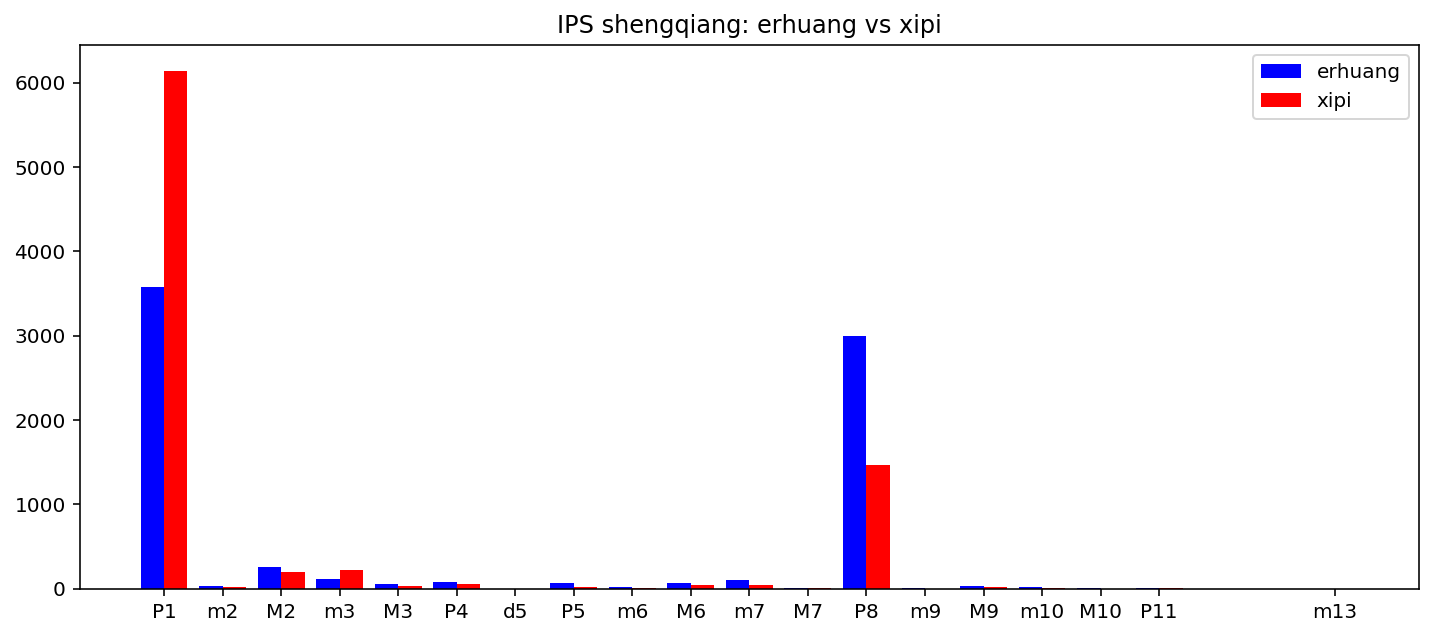

,P8,P1,P5,M7,m10,P11,m2,M6,M10,m7,M9,m3,M3,M2,P4,m6,m9,d5,m13
erhuang,2996,3577,66,4,21,3,25,66,3,98,32,115,52,262,76,18,4,1,0
xipi,1461,6138,23,4,8,3,22,40,0,43,18,225,29,198,49,11,1,0,1


In [29]:
# IPS: shengqiang interval comparative
compare_shengqiang(IPS, 'IPS shengqiang: erhuang vs xipi')

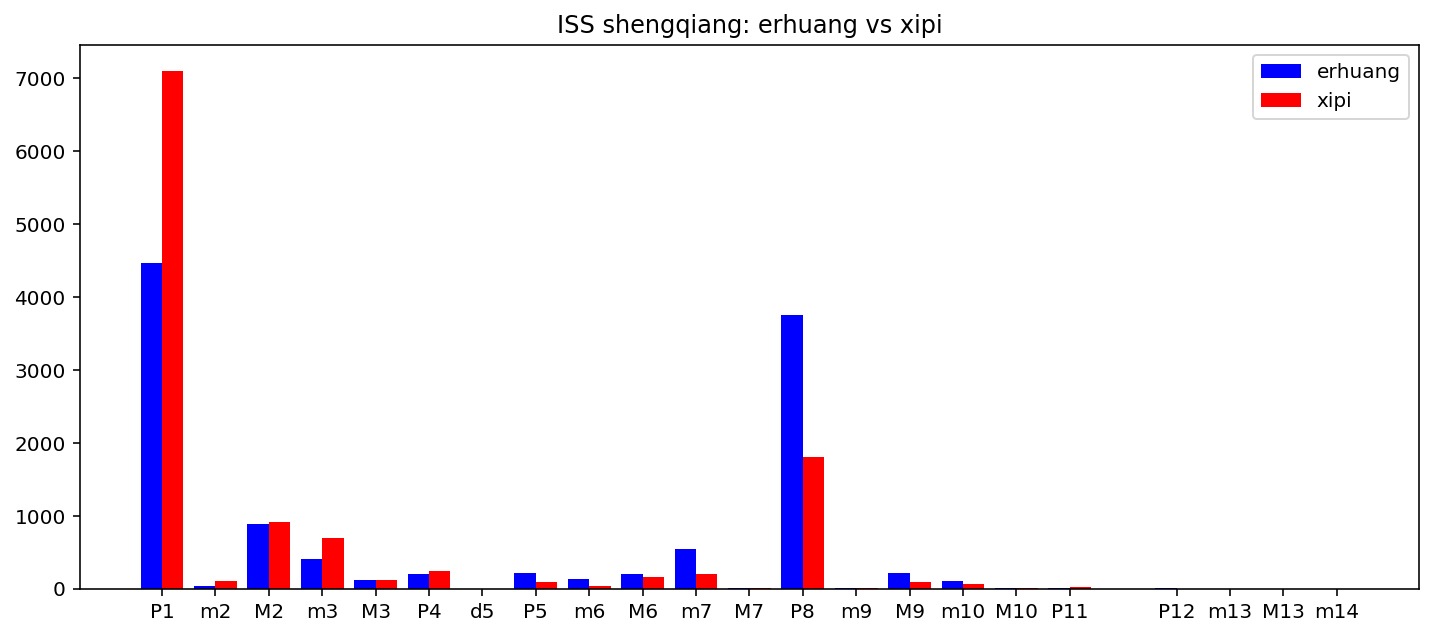

,P8,m7,m6,P4,P1,P5,M9,m3,m10,M6,M2,M7,P12,P11,m2,M10,M3,m9,A4,M13,d5,m14,m13
erhuang,3758,545,128,205,4462,215,210,406,103,201,886,8,15,14,41,8,122,11,1,1,1,0,0
xipi,1810,198,36,237,7099,93,84,696,63,156,909,7,1,21,106,4,112,9,0,0,1,1,1


In [30]:
# ISS: shengqiang interval comparative
compare_shengqiang(ISS, 'ISS shengqiang: erhuang vs xipi')

In [45]:
def get_complete_dicts_3(dict1, dict2, dict3):
    dict1_keys = dict1.keys()
    dict1_complete = dict1.copy()
    dict2_keys = dict2.keys()
    dict2_complete = dict2.copy()
    dict3_keys = dict3.keys()
    dict3_complete = dict3.copy()
    
    for i in dict1_keys:
        try:
            dict2_complete[i]
        except:
            dict2_complete[i] = 0
        try:
            dict3_complete[i]
        except:
            dict3_complete[i] = 0
            
    for i in dict2_keys:
        try:
            dict1_complete[i]
        except:
            dict1_complete[i] = 0
        try:
            dict3_complete[i]
        except:
            dict3_complete[i] = 0
            
    for i in dict3_keys:
        try:
            dict2_complete[i]
        except:
            dict2_complete[i] = 0
        try:
            dict1_complete[i]
        except:
            dict1_complete[i] = 0
    
    return dict1_complete, dict2_complete, dict3_complete

def get_x_values_MYK(xValues):
    xValuesM = []
    xValuesY = []
    xValuesK = []
    for i in xValues:
        xValuesM.append(i - 0.4)
        xValuesY.append(i)
        xValuesK.append(i + 0.4)
    return xValuesM, xValuesY, xValuesK

def compare_banshi(type_of_synchrony, plot_title):
    manban = type_of_synchrony.banshi['manban']
    yuanban = type_of_synchrony.banshi['yuanban']
    kuaiban = type_of_synchrony.banshi['kuaiban']

    manban, yuanban, kuaiban = get_complete_dicts_3(manban, yuanban, kuaiban)

    intervalsOrder = {}
    for k in manban.keys():
        itv = interval.Interval(k)
        intervalsOrder[itv.semitones] = k

    xValues = sorted(intervalsOrder.keys())
    xTicks = [intervalsOrder[i] for i in xValues]
    xValuesM, xValuesY, xValuesK = get_x_values_MYK(xValues)
    yValuesM = [manban[i] for i in xTicks]
    yValuesY = [yuanban[i] for i in xTicks]
    yValuesK = [kuaiban[i] for i in xTicks]

    banshi_labels = ['manban', 'yuanban', 'kuaiban']

    plt.figure(figsize=(12,5))
    plt.subplot()
    plt.bar(xValuesM, yValuesM, width=0.4, color='b', align='center')
    plt.bar(xValuesY, yValuesY, width=0.4, color='r', align='center')
    plt.bar(xValuesK, yValuesK, width=0.4, color='g', align='center')
    plt.xticks(xValues, xTicks)
    plt.title(plot_title)
    plt.legend(banshi_labels)
    plt.show()

    df = pd.DataFrame(data=[manban, yuanban, kuaiban], index=banshi_labels)
    display(df)

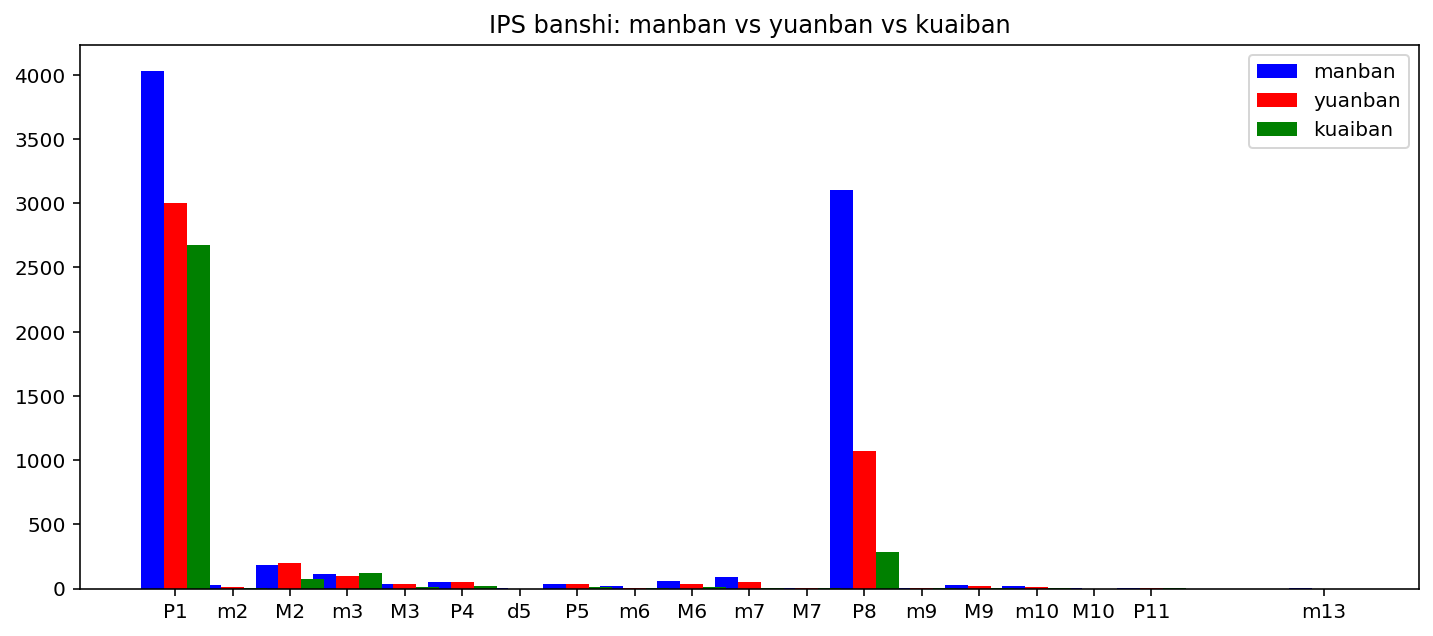

,P8,P1,P5,M7,m10,P11,m2,M6,M10,m7,M9,m3,M3,M2,P4,m6,d5,m9,m13
manban,3102,4029,39,6,17,3,26,61,3,87,28,115,38,181,50,24,1,2,1
yuanban,1072,3002,34,1,11,1,13,36,0,48,18,101,32,203,52,2,0,2,0
kuaiban,283,2677,14,1,1,2,8,9,0,6,4,119,11,72,21,2,0,1,0


In [46]:
# IPS: banshi comparative
compare_banshi(IPS, 'IPS banshi: manban vs yuanban vs kuaiban')

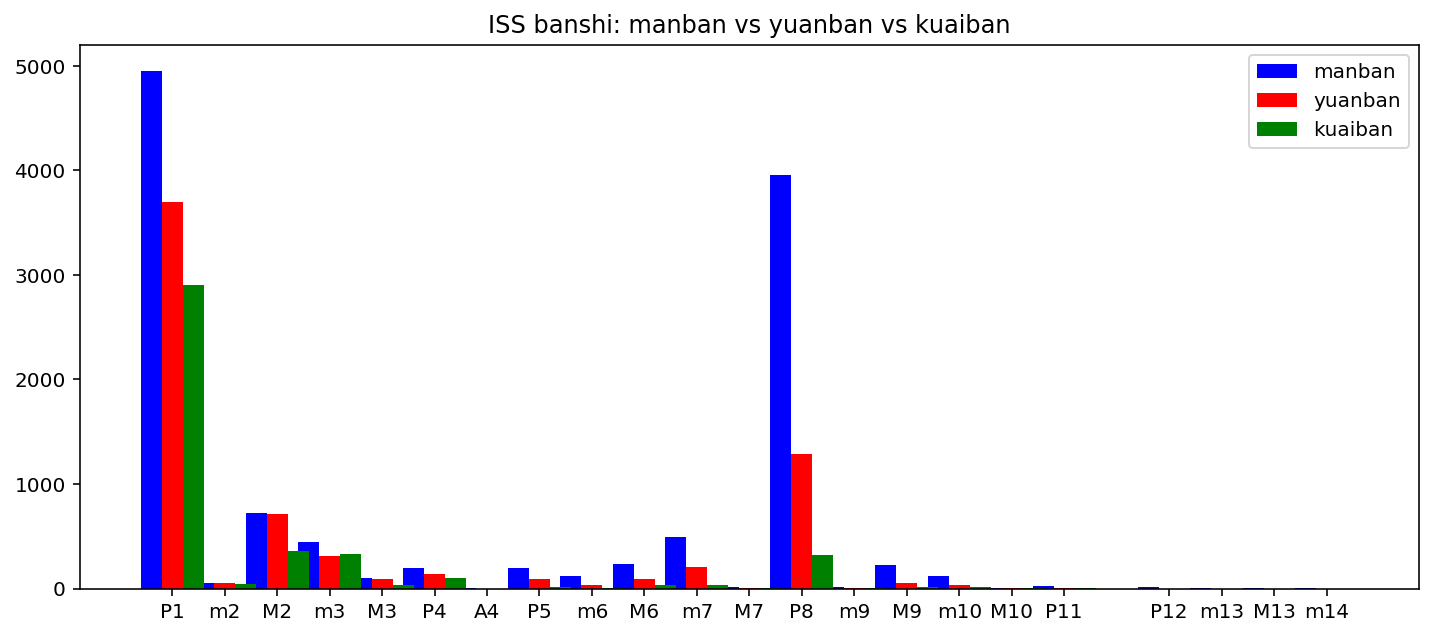

,P8,m7,m6,P4,P1,P5,M9,m3,m10,M6,M2,M7,P12,P11,m2,M10,M3,m9,d5,A4,M13,m14,m13
manban,3959,496,121,199,4951,199,221,445,116,232,722,11,16,22,56,7,106,13,2,1,1,1,1
yuanban,1284,211,34,140,3696,88,57,315,38,91,711,3,0,5,51,3,89,5,0,0,0,0,0
kuaiban,325,36,8,99,2905,19,16,333,12,34,355,1,0,8,40,2,39,2,0,0,0,0,0


In [42]:
# ISS: banshi comparative
compare_banshi(ISS, 'ISS banshi: manban vs yuanban vs kuaiban')

In [50]:
def compare_role_type(type_of_playing, plot_title):
    dan = type_of_playing.roleType['dan']
    laodan = type_of_playing.roleType['laodan']
    laosheng = type_of_playing.roleType['laosheng']
    dan, laodan, laosheng = get_complete_dicts_3(dan, laodan, laosheng)

    intervalsOrder = {}
    for k in dan.keys():
        itv = interval.Interval(k)
        intervalsOrder[itv.semitones] = k

    xValues = sorted(intervalsOrder.keys())
    xTicks = [intervalsOrder[i] for i in xValues]
    xValuesM, xValuesY, xValuesK = get_x_values_MYK(xValues)
    yValuesM = [dan[i] for i in xTicks]
    yValuesY = [laodan[i] for i in xTicks]
    yValuesK = [laosheng[i] for i in xTicks]

    role_labels = ['dan', 'laodan', 'laosheng']

    plt.figure(figsize=(12,5))
    plt.subplot()
    plt.bar(xValuesM, yValuesM, width=0.4, color='b', align='center')
    plt.bar(xValuesY, yValuesY, width=0.4, color='r', align='center')
    plt.bar(xValuesK, yValuesK, width=0.4, color='g', align='center')
    plt.xticks(xValues, xTicks)
    plt.title(plot_title)
    plt.legend(role_labels)
    plt.show()

    df = pd.DataFrame(data=[dan, laodan, laosheng], index=role_labels)
    display(df)

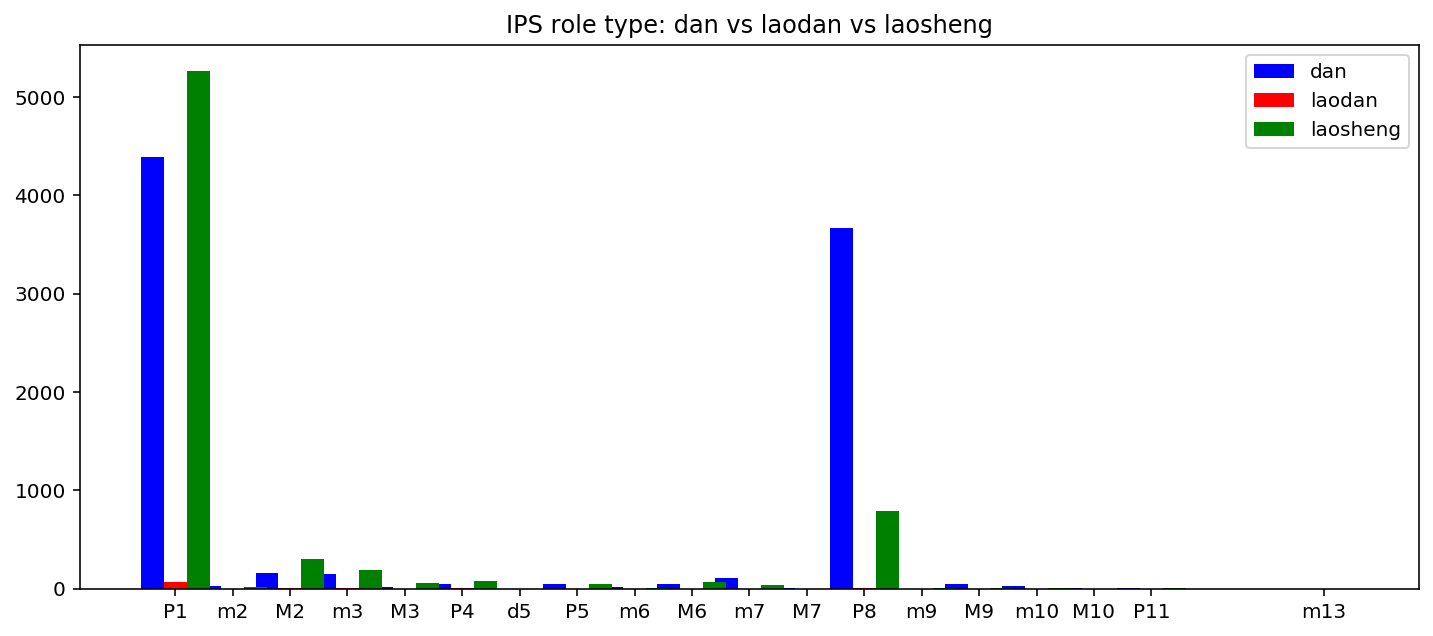

,P8,P1,P5,M7,m10,P11,m2,M6,M10,m7,M9,m3,M3,M2,P4,m6,m9,d5,m13
dan,3664,4386,45,7,26,3,27,42,3,106,42,147,21,160,44,18,1,0,0
laodan,4,65,1,0,0,0,1,1,0,0,0,3,0,4,6,0,0,1,0
laosheng,789,5264,43,1,3,3,19,63,0,35,8,190,60,296,75,11,4,0,1


In [51]:
# IPS: role type comparative
compare_role_type(IPS, 'IPS role type: dan vs laodan vs laosheng')

In [ ]:
# IPS: role type comparative
compare_role_type(IPS, 'IPS role type: dan vs laodan vs laosheng')